In [ ]:
# Imports
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import re
import dagshub
%matplotlib inline

Data -  https://www.kaggle.com/datasets/bittlingmayer/amazonreviews/code?datasetId=1305&sortBy=voteCount

In [2]:
# Read data
def parse_data(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            label, text = line.split(" ", 1)
            data.append((label, text.strip()))
    return data

train_data = parse_data('Data/train.ft.txt')
test_data = parse_data('Data/test.ft.txt')


In [3]:
# convert data into dataframe using pandas
train_df = pd.DataFrame(train_data, columns = ['Target', 'Text'])
test_df = pd.DataFrame(test_data, columns = ['Target', 'Text'])

In [4]:
train_df = train_df[:100000]

In [5]:
train_df.shape

(100000, 2)

In [6]:
train_df.head()

,Target,Text
0,__label__2,Stuning even for the non-gamer: This sound tra...
1,__label__2,The best soundtrack ever to anything.: I'm rea...
2,__label__2,Amazing!: This soundtrack is my favorite music...
3,__label__2,Excellent Soundtrack: I truly like this soundt...
4,__label__2,"Remember, Pull Your Jaw Off The Floor After He..."


In [7]:
test_df.head()

,Target,Text
0,__label__2,Great CD: My lovely Pat has one of the GREAT v...
1,__label__2,One of the best game music soundtracks - for a...
2,__label__1,Batteries died within a year ...: I bought thi...
3,__label__2,"works fine, but Maha Energy is better: Check o..."
4,__label__2,Great for the non-audiophile: Reviewed quite a...


In [8]:
# Change the target values
train_df['Target'] = train_df['Target'].map({'__label__1': 0, '__label__2': 1})
# test_df['Target'] = test_df['Target'].map({'__label__1': 0, '__label__2': 0})

In [9]:
train_df.head(2)

,Target,Text
0,1,Stuning even for the non-gamer: This sound tra...
1,1,The best soundtrack ever to anything.: I'm rea...


In [10]:
# test_df.head(2)

From the kaggle page:
- 1: Negative sentiment
- 2: Positive sentiment

Common terms:
- Corpus: Paragraph
- Documents: Lines
- Vocabulary: all unique words present in the dataset. This could either be a list, dictionary where keys would be the word in vocabulary and the value will be the frequency of the word in vocabulary. It can also be of type Counter from collections package.

In [11]:
# Get the shape of train dataset
train_df.shape

(100000, 2)

We have 3600000 documents and two columns - one for target and other for the text related to target.

In [12]:
# Count the frequency of each label
train_df['Target'].value_counts()

Target
1    51267
0    48733
Name: count, dtype: int64

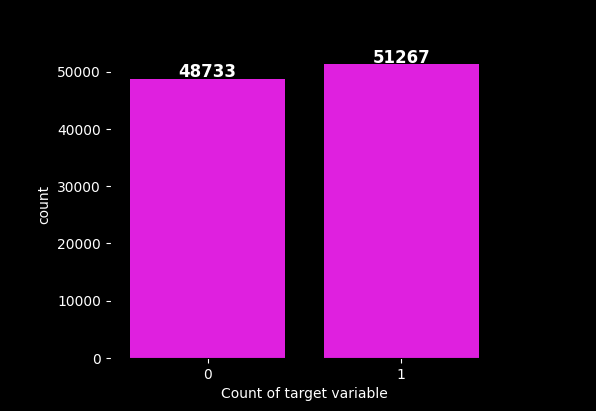

In [13]:
plt.figure(figsize=(5, 4), facecolor='black')
plt.suptitle("Plot the frequency of target variable", fontsize = 20, fontweight = 'bold')


ax = plt.subplot(1, 1, 1)
sns.countplot(data = train_df, x = 'Target', color = 'magenta')
plt.xlabel('Count of target variable')
ax.set_facecolor('black')

# Change the color of the labels an tickmarks to white

ax.ticklabel_format(style='plain', axis='y', useOffset=False)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x)}'))

ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis = 'x', colors = 'white')
ax.tick_params(axis = 'y', colors = 'white')

for p in ax.patches:
    ax.annotate(
        format(int(p.get_height())),
        (p.get_x() + p.get_width()/2, p.get_height()),
        ha = 'center', va='center',
        xytext=(0, 5),
        textcoords='offset points',
        fontsize = 12, color = 'white', weight='bold'
    )

As the both the negative and positive sentiment are exactly in same quantity therefore we have a balanced dataset. Although this happens seldomly in real life.

In [14]:
# Check for null values
train_df.isnull().sum()

Target    0
Text      0
dtype: int64

There are no null values present in the dataset

In [15]:
# Check for duplicates
train_df.duplicated().sum()

np.int64(0)

There are no duplicates present

In [16]:
# Count the total number of words in each comment
train_df['total_words_before_cleanup'] = train_df['Text'].apply(lambda x: len(x.split())) 

In [17]:
train_df.head()

,Target,Text,total_words_before_cleanup
0,1,Stuning even for the non-gamer: This sound tra...,80
1,1,The best soundtrack ever to anything.: I'm rea...,97
2,1,Amazing!: This soundtrack is my favorite music...,129
3,1,Excellent Soundtrack: I truly like this soundt...,118
4,1,"Remember, Pull Your Jaw Off The Floor After He...",87


# Data cleaning

In [18]:
text = train_df['Text'][2]

In [19]:
text

'Amazing!: This soundtrack is my favorite music of all time, hands down. The intense sadness of "Prisoners of Fate" (which means all the more if you\'ve played the game) and the hope in "A Distant Promise" and "Girl who Stole the Star" have been an important inspiration to me personally throughout my teen years. The higher energy tracks like "Chrono Cross ~ Time\'s Scar~", "Time of the Dreamwatch", and "Chronomantique" (indefinably remeniscent of Chrono Trigger) are all absolutely superb as well.This soundtrack is amazing music, probably the best of this composer\'s work (I haven\'t heard the Xenogears soundtrack, so I can\'t say for sure), and even if you\'ve never played the game, it would be worth twice the price to buy it.I wish I could give it 6 stars.'

In [20]:
# 1. Convert all words into lower case
clean_text = text.lower()
clean_text

'amazing!: this soundtrack is my favorite music of all time, hands down. the intense sadness of "prisoners of fate" (which means all the more if you\'ve played the game) and the hope in "a distant promise" and "girl who stole the star" have been an important inspiration to me personally throughout my teen years. the higher energy tracks like "chrono cross ~ time\'s scar~", "time of the dreamwatch", and "chronomantique" (indefinably remeniscent of chrono trigger) are all absolutely superb as well.this soundtrack is amazing music, probably the best of this composer\'s work (i haven\'t heard the xenogears soundtrack, so i can\'t say for sure), and even if you\'ve never played the game, it would be worth twice the price to buy it.i wish i could give it 6 stars.'

In [21]:
# 2. Remove punctuations 
# The pattern r'[^\w\s]' matches any character that is not (^) a word character (\w) or a whitespace (\s).
# It replaces those punctuation characters with an empty string ''
clean_text = re.sub(r'[^\w\s]', '', clean_text)
clean_text

'amazing this soundtrack is my favorite music of all time hands down the intense sadness of prisoners of fate which means all the more if youve played the game and the hope in a distant promise and girl who stole the star have been an important inspiration to me personally throughout my teen years the higher energy tracks like chrono cross  times scar time of the dreamwatch and chronomantique indefinably remeniscent of chrono trigger are all absolutely superb as wellthis soundtrack is amazing music probably the best of this composers work i havent heard the xenogears soundtrack so i cant say for sure and even if youve never played the game it would be worth twice the price to buy iti wish i could give it 6 stars'

In [22]:
# 3. Clean up all the special characters or letters with accents
clean_text = re.sub("@[A-Za-z0-9]+", "", clean_text)
clean_text

'amazing this soundtrack is my favorite music of all time hands down the intense sadness of prisoners of fate which means all the more if youve played the game and the hope in a distant promise and girl who stole the star have been an important inspiration to me personally throughout my teen years the higher energy tracks like chrono cross  times scar time of the dreamwatch and chronomantique indefinably remeniscent of chrono trigger are all absolutely superb as wellthis soundtrack is amazing music probably the best of this composers work i havent heard the xenogears soundtrack so i cant say for sure and even if youve never played the game it would be worth twice the price to buy iti wish i could give it 6 stars'

In [23]:
# 4. Clean up all the links
text = train_df['Text'][436]
text

'See my article "Jean Hill - The Lady in Red" online: Since writing my review of JFK: THE LAST DISSENTING WITNESS in 1998, I have been able to have my 35-page article - "Jean Hill -The Lady in Red" - included in Clint Bradford\'s JFK Assassination website. The address is: http://www.jfk-info.com/sitemap1.htm (scroll down for title).'

In [24]:
clean_text = re.sub(r'https?://\S+|www\.\S+', '', text)
clean_text

'See my article "Jean Hill - The Lady in Red" online: Since writing my review of JFK: THE LAST DISSENTING WITNESS in 1998, I have been able to have my 35-page article - "Jean Hill -The Lady in Red" - included in Clint Bradford\'s JFK Assassination website. The address is:  (scroll down for title).'

In [25]:
# 5. Remove html tags
text = train_df['Text'][44318]
text

'It AIN\'T all that!: I bought this book based on the reviews I read here, but if I could do it over, I would <b>NOT</b> buy this book.Issue #1This book has A LOT of errors. The author\'s website dismisses all the mistakes by saying, "All printed material has mistakes." First, I doubt that "all" have mistakes. Second, this book has A LOT of mistakes. I have many books and this one has the most errors. I went to their site to get the errata and found a mistake in their corrections!Issue #2The CD that comes with the book is quirky and it\'s not easy to find all stuff that\'s supposed to be on it.Issue #3Now that LearnKey is defunct, you cannot get a code to unlock the rest of the info on the CD. Instead, the autor\'s site charges for a new, unlocked CD.Go for another, more reliable book! Unless you enjoy wasting money for misinformation.'

In [26]:
cleaned_text = re.sub(r'<.*?>', '', text)
cleaned_text

'It AIN\'T all that!: I bought this book based on the reviews I read here, but if I could do it over, I would NOT buy this book.Issue #1This book has A LOT of errors. The author\'s website dismisses all the mistakes by saying, "All printed material has mistakes." First, I doubt that "all" have mistakes. Second, this book has A LOT of mistakes. I have many books and this one has the most errors. I went to their site to get the errata and found a mistake in their corrections!Issue #2The CD that comes with the book is quirky and it\'s not easy to find all stuff that\'s supposed to be on it.Issue #3Now that LearnKey is defunct, you cannot get a code to unlock the rest of the info on the CD. Instead, the autor\'s site charges for a new, unlocked CD.Go for another, more reliable book! Unless you enjoy wasting money for misinformation.'

In [27]:
# 6. Remove any email address
text = train_df['Text'][291]
text

'I feel ya "Ghenry187@aol"...this CD rocks. No Limit can\'t...: I feel ya "Ghenry187@aol.com"...this CD rocks. No Limit can\'t touch Cash $ Money Records. I don\'t know why that new Tru CD sold one million in the first place. Who cares, \'cause I just checked the billboard charts and discovered that Juvenile sold more that two million. So they can\'t be faded. Anyway, back to this CD. Every song on this CD rocks. My favorite song is "Help" by B.G. I love this CD.'

In [28]:
clean_text = re.sub(r'\S+@\S+', '', text)
clean_text

'I feel ya  CD rocks. No Limit can\'t...: I feel ya  CD rocks. No Limit can\'t touch Cash $ Money Records. I don\'t know why that new Tru CD sold one million in the first place. Who cares, \'cause I just checked the billboard charts and discovered that Juvenile sold more that two million. So they can\'t be faded. Anyway, back to this CD. Every song on this CD rocks. My favorite song is "Help" by B.G. I love this CD.'

In [29]:
# 7. Remove any mentions
text = train_df['Text'][18367]
text

'The Ultimate Movie Review! - [...] - @tss5078: ...except it\'s not! This film is supposed to be an uplifting comedy, however I found it painfully predictable and a bit sad. Keir Gilchrist was great, playing Craig, a young mental patient who wants to kill himself. Gilchrist and the flashes of his thoughts, that we get to see, are the best part of this film and the only thing really worth seeing. Zach Galifianakis, who is one of my favorites, isn\'t at all funny, he\'s actually kind of pathetic in this film. Despite Gilchrist performance, the movie is actually quite stupid, I mean what kind of mental hospital lets the patients have access to the roof of the hospital? It looked good, has some really good actors in it, but nothing happens, the story is predictable as hell, and it\'s a "comedy" in which no one really says or does anything funny. I was hugely disappointed with it.'

In [30]:
clean_text = re.sub(r'@\w+', '', text)
clean_text

'The Ultimate Movie Review! - [...] - : ...except it\'s not! This film is supposed to be an uplifting comedy, however I found it painfully predictable and a bit sad. Keir Gilchrist was great, playing Craig, a young mental patient who wants to kill himself. Gilchrist and the flashes of his thoughts, that we get to see, are the best part of this film and the only thing really worth seeing. Zach Galifianakis, who is one of my favorites, isn\'t at all funny, he\'s actually kind of pathetic in this film. Despite Gilchrist performance, the movie is actually quite stupid, I mean what kind of mental hospital lets the patients have access to the roof of the hospital? It looked good, has some really good actors in it, but nothing happens, the story is predictable as hell, and it\'s a "comedy" in which no one really says or does anything funny. I was hugely disappointed with it.'

In [31]:
# Let us put this all in a single function that can be applied to the full text column in the dataframe

def data_cleaning(text):
    clean_text = text.lower()
    clean_text = re.sub(r'[^\w\s]', '', clean_text)
    clean_text = re.sub(r'https?://\S+|www\.\S+', '', clean_text)
    clean_text = re.sub(r'<.*?>', '', clean_text)
    clean_text = re.sub(r'\S+@\S+', '', clean_text)
    clean_text = re.sub(r'@\w+', '', clean_text)
    clean_text = re.sub("@[A-Za-z]+", "", clean_text)
    return clean_text    

In [32]:
# Clean the dataframe by applying this function
train_df['clean_text'] = train_df['Text'].apply(data_cleaning) 

In [33]:
train_df.head(5)

,Target,Text,total_words_before_cleanup,clean_text
0,1,Stuning even for the non-gamer: This sound tra...,80,stuning even for the nongamer this sound track...
1,1,The best soundtrack ever to anything.: I'm rea...,97,the best soundtrack ever to anything im readin...
2,1,Amazing!: This soundtrack is my favorite music...,129,amazing this soundtrack is my favorite music o...
3,1,Excellent Soundtrack: I truly like this soundt...,118,excellent soundtrack i truly like this soundtr...
4,1,"Remember, Pull Your Jaw Off The Floor After He...",87,remember pull your jaw off the floor after hea...


# NLTK

In [34]:
import nltk
from nltk.corpus import stopwords
nltk_stopwords = set(stopwords.words('english'))

# Let us print the stopwords from nltk library
print(nltk_stopwords)

{'him', 'doesn', "you'd", 'was', 'll', 'hadn', 'are', 'hers', 'by', 'shan', "you've", 'both', 'once', 'myself', 've', 'couldn', "doesn't", 'again', 'yourselves', 'a', "won't", 'our', 'these', 're', 'theirs', 'between', 'won', 'over', "should've", 'mustn', 'haven', 'how', 'very', 'ain', 'here', 'where', 'only', "wasn't", "she's", "couldn't", "don't", 'i', 'when', 'have', 'such', 'd', 'themselves', 'your', 'off', 'above', 'from', 'out', 'should', 'needn', 'can', 'more', 'y', 'and', 'me', 'up', 'her', 'whom', 'isn', 'she', 'until', 'ma', 'the', 'each', 'of', 'yours', 'into', 'which', 'or', "you're", "you'll", 'he', 'most', 'other', 'will', 't', "shouldn't", 'this', 'that', 'no', 's', 'before', 'his', 'herself', 'their', 'not', 'weren', 'further', 'am', 'them', "it's", 'an', 'is', "needn't", 'under', 'do', "hasn't", 'wasn', 'you', 'because', 'has', 'does', 'be', "mightn't", 'it', 'itself', "hadn't", 'shouldn', 'during', 'they', 'having', 'o', 'then', 'just', 'himself', "aren't", 'we', 'did

In [35]:
len(nltk_stopwords)

179

In [36]:
# Some of the words like not, too, never express the sentiment and we do not want to loose it. So I have created this updated
# stop words list and we will only remove these stop words. 
cleaned_stopwords = {
    'most', 'now', 'were', 'itself', 'doing', 'again', 're', 'before', 'whom', 'has', 
    "you're", 'he', 'hers', 'her', 'who', "you'll", 've', 'all', 'did', 'herself', 'are', 
    'that', 'off', 'for', 'this', 'o', 'then', 'your', 'into', 'we', 'as', "it's", 'from', 
    'been', 'yours', 'm', 'below', 'y', 'the', 'these', 'than', 'down', 'himself', 'themselves', 
    'at', 'our', 'under', 'is', 'against', 's', 'few', 'other', 'theirs', 'me', 'there', 'you', 
    'ourselves', 'i', 'own', 'during', 'd', 'myself', 'further', 'had', 'while', 'out', "she's", 
    'over', "that'll", 'with', 'if', 'do', 'yourself', 'ma', 'my', 'between', 'any', 'on', 
    "should've", "you'd", 'their', 'an', 'ours', 'him', 'here', 'through', 'such', 'above', 
    'but', 'or', 'same', 'which', 'a', 'of', 'having', 'about', 'its', 'does', 'to', 'being', 
    "you've", 'those', 't', 'be', 'in', 'nor', 'hadn', 'she', 'have', 'll', 'once', 'them', 
    'after', 'by', 'until', 'and', 'it', 'each', 'yourselves', "hadn't"
}

In [37]:
len(cleaned_stopwords)

120

In [38]:
# Now we can do either stemming or lemmatization. 
# Stemming is not so great as sometimes meaning of words get changed. 
# Therefore we will use lemmatisation

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [39]:
text = train_df['Text'][1]
new_sentence = ''
for token in text.split():
    new_sentence = new_sentence + lemmatizer.lemmatize(token) + ' '

new_sentence

"The best soundtrack ever to anything.: I'm reading a lot of review saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for year now and it beauty simply refuse to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would be worth every penny. "

In [40]:
def lemmatize_clean_data(text):
    new_sentence = ''
    for token in text.split():
        new_sentence = new_sentence + lemmatizer.lemmatize(token) + ' '
    return new_sentence

def remove_stop_words(text):
    new_sentence = ''
    for token in text.split(): 
        if token not in cleaned_stopwords:
            new_sentence = new_sentence + token + ' '
    return new_sentence



In [41]:
train_df['clean_text'] = train_df['clean_text'].apply(lemmatize_clean_data)

In [42]:
train_df['clean_text_without_stopwords'] = train_df['clean_text'].apply(remove_stop_words)

In [43]:
train_df['total_words_clean_text'] = train_df['clean_text'].apply(lambda x: len(x.split())) 
train_df['total_words_clean_text_without_stopwords'] = train_df['clean_text_without_stopwords'].apply(lambda x: len(x.split())) 

In [44]:
train_df.head()

,Target,Text,total_words_before_cleanup,clean_text,clean_text_without_stopwords,total_words_clean_text,total_words_clean_text_without_stopwords
0,1,Stuning even for the non-gamer: This sound tra...,80,stuning even for the nongamer this sound track...,stuning even nongamer sound track wa beautiful...,80,47
1,1,The best soundtrack ever to anything.: I'm rea...,97,the best soundtrack ever to anything im readin...,best soundtrack ever anything im reading lot r...,97,50
2,1,Amazing!: This soundtrack is my favorite music...,129,amazing this soundtrack is my favorite music o...,amazing soundtrack favorite music time hand in...,128,76
3,1,Excellent Soundtrack: I truly like this soundt...,118,excellent soundtrack i truly like this soundtr...,excellent soundtrack truly like soundtrack enj...,116,73
4,1,"Remember, Pull Your Jaw Off The Floor After He...",87,remember pull your jaw off the floor after hea...,remember pull jaw floor hearing youve played g...,87,51


In [45]:
train_df['total_words_clean_text'].describe()

count    100000.000000
mean         79.530930
std          43.101658
min           4.000000
25%          43.000000
50%          72.000000
75%         110.000000
max         241.000000
Name: total_words_clean_text, dtype: float64

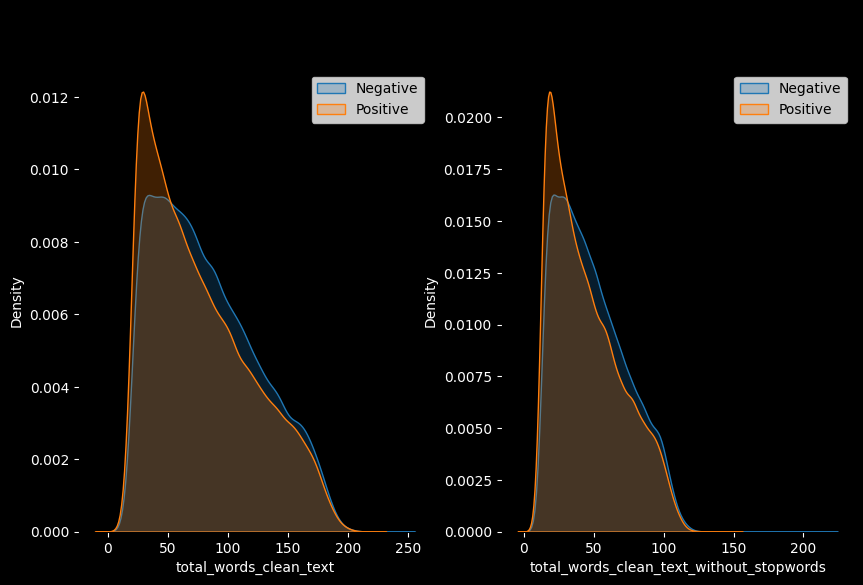

In [46]:
# Let us try to plot a kde to understand the distribution of words
plt.figure(figsize=(10, 6), facecolor='black')
plt.suptitle("Plot the frequency of words", fontsize = 20, fontweight = 'bold')
col = ['total_words_clean_text', 'total_words_clean_text_without_stopwords']

for i in range(len(col)):
    ax = plt.subplot(1, 2, i+1)
    sns.kdeplot(train_df[train_df['Target'] == 0][col[i]], label = 'Negative', fill = True)
    sns.kdeplot(train_df[train_df['Target'] == 1][col[i]], label = 'Positive', fill = True)
    plt.legend()
    ax.set_facecolor('black')
    ax.xaxis.label.set_color('white')
    ax.yaxis.label.set_color('white')
    ax.tick_params(axis = 'x', colors = 'white')
    ax.tick_params(axis = 'y', colors = 'white')

Observations from above kde
1. When the stop words were not removed then our distribution was wider. This makes sense as well as there are lots of words. Peak is also not as high.
2. when the stop words are removed then our distribution became narrower. This clearly shows that our stop words were removed. Peak also went higher for same reason as now we have more concentration of comments with word count between 30-80 words approximately. 
3. A word count of 50 is more characteristic of positive comments than of negative ones. 

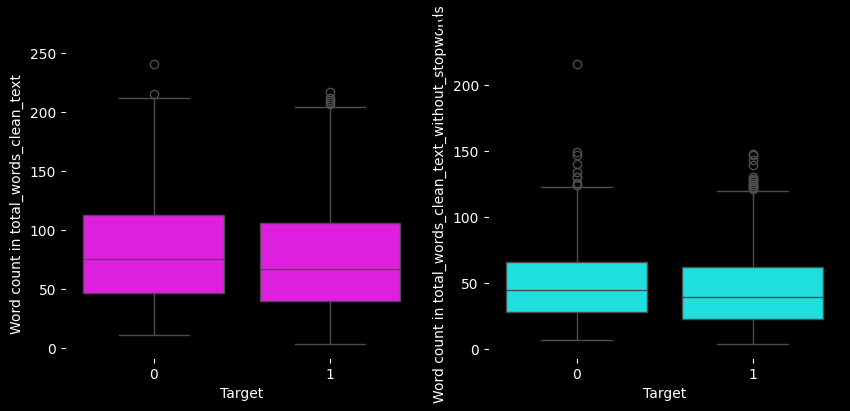

In [47]:
# Let us plot blox plot to understand if word count can help decipher if the comment is negative or positive?

plt.figure(figsize =(10, 4), facecolor='black')
col = ['total_words_clean_text', 'total_words_clean_text_without_stopwords']
plt.suptitle("Word count by target", fontsize = 20, fontweight = 'bold')
color = ['magenta', 'cyan']

for i in range(len(col)):
    ax = plt.subplot(1, 2, i+1)
    sns.boxplot(data = train_df, x = 'Target', y = col[i], color = color[i])
    plt.xlabel('Target')
    plt.ylabel(f'Word count in {col[i]}')
    ax.set_facecolor('black')
    ax.xaxis.label.set_color('white')
    ax.yaxis.label.set_color('white')
    ax.tick_params(axis = 'x', colors = 'white')
    ax.tick_params(axis = 'y', colors = 'white')

Observations of the box plot
1. Lower rating has more outliers than higher rating. This can mean that if there are higher than ordinary number of words in a review then chances are that the review is with a lower rating.
2. Both the word count with stop words and word count without stop words behave in a similar mannner with respect to the target variable. 
3. Both the word counts have median very close to one another. 

In [48]:
# Create a frequency distribution of words with respect to both the word counts
from collections import Counter

# for clean_text column
total_words_clean_text_list = [word for comment in train_df['clean_text'] for word in comment.split()]
most_common_words_clean_text = Counter(total_words_clean_text_list).most_common(25)
top_25_total_words_clean_text_df = pd.DataFrame(most_common_words_clean_text, columns = ['word', 'count'])

# for clean_text_without_stopwords column
total_words_clean_text_without_stopwords_list = [word for comment in train_df['clean_text_without_stopwords'] for word in comment.split()]
most_common_words_clean_text_without_stopwords = Counter(total_words_clean_text_without_stopwords_list).most_common(25)
top_25_total_words_total_words_clean_text_without_stopwords_df = pd.DataFrame(most_common_words_clean_text_without_stopwords, columns = ['word', 'count'])

C:\Users\RadhikaMaheshwari\AppData\Local\Temp\ipykernel_27384\3578561623.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = top_25_total_words_clean_text_df,
C:\Users\RadhikaMaheshwari\AppData\Local\Temp\ipykernel_27384\3578561623.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = top_25_total_words_total_words_clean_text_without_stopwords_df,


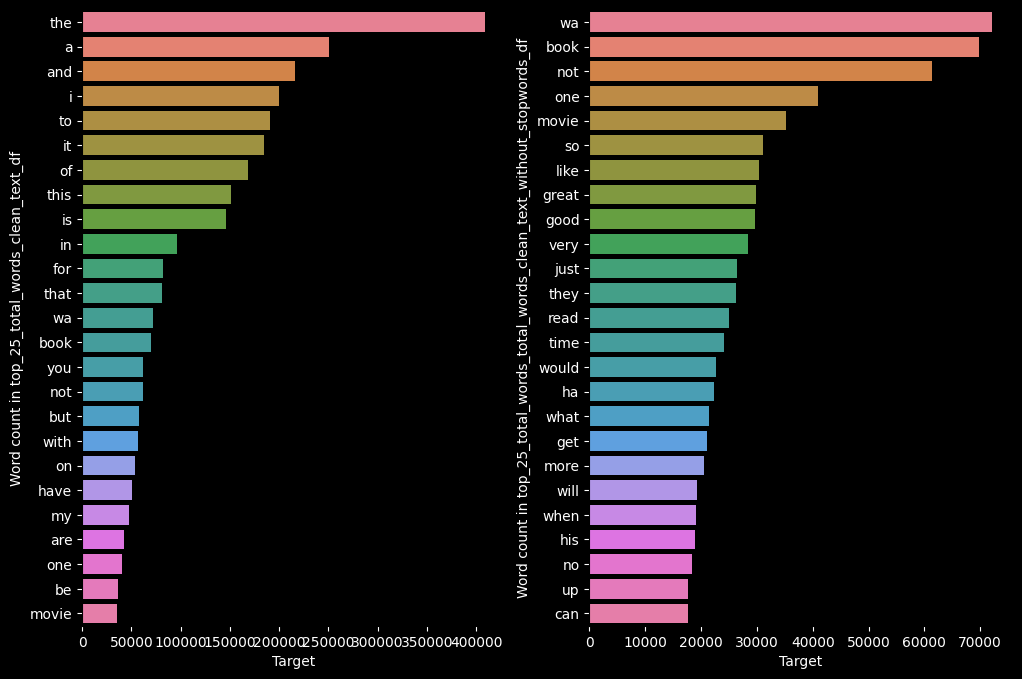

In [49]:
# Let us plot these top 25 words
col = [top_25_total_words_clean_text_df, top_25_total_words_total_words_clean_text_without_stopwords_df]

plt.figure(figsize = (12, 8), facecolor='black')

ax = plt.subplot(1, 2, 1)
sns.barplot(data = top_25_total_words_clean_text_df, 
            x = top_25_total_words_clean_text_df['count'], 
            y = top_25_total_words_clean_text_df['word'],
            palette='husl')
plt.xlabel('Target')
plt.ylabel(f'Word count in top_25_total_words_clean_text_df')
ax.set_facecolor('black')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis = 'x', colors = 'white')
ax.tick_params(axis = 'y', colors = 'white')

ax = plt.subplot(1, 2, 2)
sns.barplot(data = top_25_total_words_total_words_clean_text_without_stopwords_df, 
            x = top_25_total_words_total_words_clean_text_without_stopwords_df['count'], 
            y = top_25_total_words_total_words_clean_text_without_stopwords_df['word'],
            palette='husl')
plt.xlabel('Target')
plt.ylabel(f'Word count in top_25_total_words_total_words_clean_text_without_stopwords_df')
ax.set_facecolor('black')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis = 'x', colors = 'white')
ax.tick_params(axis = 'y', colors = 'white')

Observations from the above Bar plots
WRITE THEM


# Separate dependent and independent variables

In [50]:
train_df.head(1)

,Target,Text,total_words_before_cleanup,clean_text,clean_text_without_stopwords,total_words_clean_text,total_words_clean_text_without_stopwords
0,1,Stuning even for the non-gamer: This sound tra...,80,stuning even for the nongamer this sound track...,stuning even nongamer sound track wa beautiful...,80,47


In [51]:
# Let us first separate our dependent and independent features for clean_text
train_df_clean_text_X = train_df[['clean_text', 'total_words_clean_text']]
train_df_clean_text_y = train_df[['Target']]

In [52]:
train_df_clean_text_X.head(1)

,clean_text,total_words_clean_text
0,stuning even for the nongamer this sound track...,80


In [53]:
train_df_clean_text_y.head(1)

,Target
0,1


In [54]:
# Let us separate our dependent and independent features for clean_text_without_stopwords
train_df_clean_text_without_stopwords_X = train_df[['clean_text_without_stopwords', 'total_words_clean_text_without_stopwords']]
train_df_clean_text_without_stopwords_y = train_df[['Target']]

In [55]:
train_df_clean_text_without_stopwords_X.head(1)

,clean_text_without_stopwords,total_words_clean_text_without_stopwords
0,stuning even nongamer sound track wa beautiful...,47


In [56]:
train_df_clean_text_without_stopwords_y.head(1)

,Target
0,1


# Train test spit
Important: We already have a train and test datasets separately. 
I am going to still do train test split to split the train dataset into train and validation datasets. This ensures that we have a mechanism to understand how our model will perform with new data. Once we are satisfied with the training and validation performance metrics then we will use the test dataset to do our predictions and keep evaluating the performance. 

In [57]:
# Splitting the train dataset into training and validation datasets
from sklearn.model_selection import train_test_split
# train test split for clean text
X_train_clean_text, X_val_clean_text, y_train_clean_text, y_val_clean_text = train_test_split(train_df_clean_text_X, 
train_df_clean_text_y,
test_size=0.30, 
random_state=42)

# Train test split for clean_text_without_stopwords = 
X_train_clean_text_without_stopwords, X_val_clean_text_without_stopwords, y_train_clean_text_without_stopwords, y_val_clean_text_without_stopwords =  train_test_split(train_df_clean_text_without_stopwords_X,
                 train_df_clean_text_without_stopwords_y,
                 test_size=0.30,
                 random_state=42)

In [58]:
print(f"X_train_clean_text.shape - {X_train_clean_text.shape}")
print(f"X_val_clean_text.shape - {X_val_clean_text.shape}")
print(f"y_train_clean_text.shape - {y_train_clean_text.shape}")
print(f"y_val_clean_text.shape - {y_val_clean_text.shape}")

X_train_clean_text.shape - (70000, 2)
X_val_clean_text.shape - (30000, 2)
y_train_clean_text.shape - (70000, 1)
y_val_clean_text.shape - (30000, 1)


In [59]:
print(f"X_train_clean_text_without_stopwords.shape - {X_train_clean_text_without_stopwords.shape}")
print(f"X_val_clean_text_without_stopwords.shape - {X_val_clean_text_without_stopwords.shape}")
print(f"y_train_clean_text_without_stopwords.shape - {y_train_clean_text_without_stopwords.shape}")
print(f"y_val_clean_text_without_stopwords.shape - {y_val_clean_text_without_stopwords.shape}")

X_train_clean_text_without_stopwords.shape - (70000, 2)
X_val_clean_text_without_stopwords.shape - (30000, 2)
y_train_clean_text_without_stopwords.shape - (70000, 1)
y_val_clean_text_without_stopwords.shape - (30000, 1)


It is important to do train validation split before we apply model building to avoid data leakage. 

# Bag of Words for clean_text

In [60]:
# Let us use Bag of Words to understand if we can predict the sentiment
from sklearn.feature_extraction.text import CountVectorizer
cv_default = CountVectorizer()
cv_default_clean_text = cv_default.fit_transform(X_train_clean_text['clean_text'])

In [61]:
# Let us check the shape of the cv_default_clean_text
cv_default_clean_text.shape

(70000, 135202)

In [62]:
# This means there are 2520000 rows and 1785512 is the vocab size created by Bag of Words.

In [63]:
# Get the names of the features
cv_default.get_feature_names_out()[:50]

array(['00', '000', '00000000001', '0001', '00045', '001', '001past',
       '002', '0020955707', '0023', '0025', '002literally', '003',
       '003mm0012', '005', '0051mm002fast', '007', '0080', '00lyrics',
       '00s', '01', '010', '010all', '010blue', '010flying', '010i',
       '010your', '012', '013', '0130112518', '0130944106', '0148813910',
       '016071', '018', '01fz', '01only', '02', '020', '027', '028',
       '029', '03', '031402', '03609na', '039', '04', '040', '040302',
       '045', '046'], dtype=object)

In [64]:
# Let us check the type of each row
type(cv_default_clean_text[0])

scipy.sparse._csr.csr_matrix

In [65]:
X_train_clean_text['clean_text'].iloc[12]

'intense chemical fume the fragrance on this product is egregiously intense in fact i tried to air twenty of them out in a closed room and the air in that room over a matter of day would make you light headed and naseus dont buy them '

In [66]:
# Vocab words back from the Count Vectorizer
cv_default.inverse_transform(np.asarray(cv_default_clean_text[12].todense()))


[array(['air', 'and', 'buy', 'chemical', 'closed', 'day', 'dont',
        'egregiously', 'fact', 'fragrance', 'fume', 'headed', 'in',
        'intense', 'is', 'light', 'make', 'matter', 'naseus', 'of', 'on',
        'out', 'over', 'product', 'room', 'that', 'the', 'them', 'this',
        'to', 'tried', 'twenty', 'would', 'you'], dtype='<U196')]

In [67]:
# Let us transform the validation set as well.
cv_default_val_clean_text = cv_default.transform(X_val_clean_text['clean_text'])

Let us build the model with 
- Only clean words but which contain stop words
- Default configuration of Count Vectorizer

# Model Building for clean_text

In [68]:
import sys
from sklearn.linear_model import LogisticRegression


# Flatten the target variable as Scikit learn Logistic regression requires series and not dataframe.
y_train_clean_text_flat = y_train_clean_text['Target']
y_val_clean_text_flat = y_val_clean_text['Target']

# Create and train the logistic regression model
logistic_regression_clean_text_1 = LogisticRegression(solver = 'liblinear',
                                                      random_state = 42)
logistic_regression_clean_text_1.fit(cv_default_clean_text,
                                     y_train_clean_text_flat)

# Calculate scores. This is a balanced dataset so we can directly evaluate accuracy. 
clean_text_train_score = logistic_regression_clean_text_1.score(cv_default_clean_text,
                                                                y_train_clean_text_flat)
clean_text_val_score = logistic_regression_clean_text_1.score(cv_default_val_clean_text,
                                                              y_val_clean_text_flat)

print(f"clean_text_train_score = {clean_text_train_score}")
print(f'clean_text_val_score = {clean_text_val_score}')


clean_text_train_score = 0.9776857142857143
clean_text_val_score = 0.8837666666666667


In [69]:
#############################################################################
# USing both the features
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
preprocessor_1 = ColumnTransformer([
    ('text_features', CountVectorizer(), 'clean_text'),
    ('numerical_features', StandardScaler(), ['total_words_clean_text'])
], remainder='drop')

pipeline1 = Pipeline([
    ('preprocessor', preprocessor_1),
    ('classifier', LogisticRegression(solver = 'liblinear', random_state = 42))
])

param_grid = {
    # Text vectorizer parameters
    'preprocessor__text_features__max_features': [None, 10000],
    'preprocessor__text_features__ngram_range': [(1, 1), (1, 3)],
    # Classifier parameters
    'classifier__C': [0.1, 1.0],
    'classifier__penalty': ['l1', 'l2']
}

logistic_regression_gridsearchcv = GridSearchCV(
    estimator=pipeline1,
    param_grid=param_grid,
    cv = 3,
    n_jobs = -1,
    verbose = 1
)


logistic_regression_gridsearchcv.fit(X_train_clean_text, y_train_clean_text_flat)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


,estimator,Pipeline(step...liblinear'))])
,param_grid,"{'classifier__C': [0.1, 1.0], 'classifier__penalty': ['l1', 'l2'], 'preprocessor__text_features__max_features': [None, 10000], 'preprocessor__text_features__ngram_range': [(1, ...), (1, ...)]}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('text_features', ...), ('numerical_features', ...)]"


In [70]:
# 🎯 Understanding GridSearchCV Results
print("GRIDSEARCHCV RESULTS ANALYSIS")
print("="*50)

print("WHAT BEST_SCORE_ MEANS:")
print(f"   Best CV Score: {logistic_regression_gridsearchcv.best_score_:.4f}")
print("   ↳ This is the AVERAGE accuracy across 5 folds for the BEST parameter combination")
print("   ↳ It's the highest cross-validation score achieved among all 54 parameter combinations")
print()

print("WHAT BEST_PARAMS_ MEANS:")
best_params = logistic_regression_gridsearchcv.best_params_
for param, value in best_params.items():
    print(f"   {param}: {value}")
print("   ↳ These are the parameter values that achieved the best_score_")
print()

print("WHAT BEST_INDEX_ MEANS:")
print(f"   Best Index: {logistic_regression_gridsearchcv.best_index_}")
print("   ↳ This is the position (0-53) of the best combination in the search space")
print()

print("HOW BEST_SCORE_ IS CALCULATED:")
print("   For the winning parameter combination:")
print("   1. Model trained on Fold 1 (80%) → tested on Fold 1 (20%) → Score 1")
print("   2. Model trained on Fold 2 (80%) → tested on Fold 2 (20%) → Score 2") 
print("   3. Model trained on Fold 3 (80%) → tested on Fold 3 (20%) → Score 3")
print("   4. Model trained on Fold 4 (80%) → tested on Fold 4 (20%) → Score 4")
print("   5. Model trained on Fold 5 (80%) → tested on Fold 5 (20%) → Score 5")
print(f"   best_score_ = Average(Score1, Score2, Score3, Score4, Score5) = {logistic_regression_gridsearchcv.best_score_:.4f}")
print()

print("INTERPRETATION:")
if logistic_regression_gridsearchcv.best_score_ > 0.90:
    print("EXCELLENT performance (>90%)")
elif logistic_regression_gridsearchcv.best_score_ > 0.85:
    print("VERY GOOD performance (85-90%)")
elif logistic_regression_gridsearchcv.best_score_ > 0.80:
    print("GOOD performance (80-85%)")
else:
    print("Could be better (<80%)")

print(f"   This means on average, the model correctly classifies {logistic_regression_gridsearchcv.best_score_*100:.1f}% of reviews")

GRIDSEARCHCV RESULTS ANALYSIS
WHAT BEST_SCORE_ MEANS:
   Best CV Score: 0.9064
   ↳ This is the AVERAGE accuracy across 5 folds for the BEST parameter combination
   ↳ It's the highest cross-validation score achieved among all 54 parameter combinations

WHAT BEST_PARAMS_ MEANS:
   classifier__C: 1.0
   classifier__penalty: l2
   preprocessor__text_features__max_features: None
   preprocessor__text_features__ngram_range: (1, 3)
   ↳ These are the parameter values that achieved the best_score_

WHAT BEST_INDEX_ MEANS:
   Best Index: 13
   ↳ This is the position (0-53) of the best combination in the search space

HOW BEST_SCORE_ IS CALCULATED:
   For the winning parameter combination:
   1. Model trained on Fold 1 (80%) → tested on Fold 1 (20%) → Score 1
   2. Model trained on Fold 2 (80%) → tested on Fold 2 (20%) → Score 2
   3. Model trained on Fold 3 (80%) → tested on Fold 3 (20%) → Score 3
   4. Model trained on Fold 4 (80%) → tested on Fold 4 (20%) → Score 4
   5. Model trained on Fo

In [71]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score

In [72]:
# 🔍 Model Performance Evaluation
print("\n" + "="*60)
print("FINAL MODEL EVALUATION")
print("="*60)

# Get the best model and evaluate on validation set
best_model = logistic_regression_gridsearchcv.best_estimator_
train_predictions = best_model.predict(X_train_clean_text)
val_predictions = best_model.predict(X_val_clean_text)

recall_score_train = recall_score(y_train_clean_text_flat,
                                                         train_predictions)
recall_score_val = recall_score(y_val_clean_text_flat,
                                val_predictions)
precision_score_train = precision_score(y_train_clean_text_flat,
                                                         train_predictions)
precision_score_val = precision_score(y_val_clean_text_flat,
                                val_predictions)

accuracy_score_train = accuracy_score(y_train_clean_text_flat,
                                                         train_predictions)
accuracy_score_val = accuracy_score(y_val_clean_text_flat,
                                val_predictions)

val_score = best_model.score(X_val_clean_text, y_val_clean_text_flat)


print("SCORE COMPARISON:")
print(f"   Cross-Validation Score (best_score_): {logistic_regression_gridsearchcv.best_score_:.4f}")
print(f"   Validation Set Score:                  {val_score:.4f}")
print(f' Recall Score Train= {recall_score_train}')
print(f' Recall Score Val= {recall_score_val}')
print(f' Precision Score Train= {precision_score_train}')
print(f' Recall Score Val= {precision_score_val}')
print(f' Accuracy Score Train= {accuracy_score_train}')
print(f' Accuracy Score Val= {accuracy_score_val}')

difference = val_score - logistic_regression_gridsearchcv.best_score_
print("SCORE DIFFERENCE ANALYSIS:")
if abs(difference) < 0.01:
    print(f"   Difference: {difference:+.4f} - EXCELLENT! Very consistent performance")
elif abs(difference) < 0.02:
    print(f"   Difference: {difference:+.4f} - GOOD! Reasonably consistent")
elif difference < -0.02:
    print(f"   Difference: {difference:+.4f} - Possible overfitting to CV folds")
else:
    print(f"   Difference: {difference:+.4f} - Validation set easier than CV average")

print()
print("WHAT THIS MEANS:")
print("   - best_score_ = Average performance across 5 different train/val splits")
print("   - validation score = Performance on your specific validation set")
print("   - Small difference = Model generalizes well to unseen data")
print("   - Large negative difference = Model might be overfitting")

print(f"\nBOTTOM LINE:")
print(f"   Your model achieves ~{val_score*100:.1f}% accuracy on new, unseen data")
print(f"   This is {'excellent' if val_score > 0.90 else 'very good' if val_score > 0.85 else 'good' if val_score > 0.80 else 'decent'} for sentiment analysis!")


FINAL MODEL EVALUATION
SCORE COMPARISON:
   Cross-Validation Score (best_score_): 0.9064
   Validation Set Score:                  0.9148
 Recall Score Train= 1.0
 Recall Score Val= 0.9175894926603142
 Precision Score Train= 1.0
 Recall Score Val= 0.9178258629572386
 Accuracy Score Train= 1.0
 Accuracy Score Val= 0.9148
SCORE DIFFERENCE ANALYSIS:
   Difference: +0.0084 - EXCELLENT! Very consistent performance

WHAT THIS MEANS:
   - best_score_ = Average performance across 5 different train/val splits
   - validation score = Performance on your specific validation set
   - Small difference = Model generalizes well to unseen data
   - Large negative difference = Model might be overfitting

BOTTOM LINE:
   Your model achieves ~91.5% accuracy on new, unseen data
   This is excellent for sentiment analysis!


# ML Flow Implementation

In [76]:
import dagshub

ModuleNotFoundError: No module named 'dagshub'

In [ ]:
import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient
import os
import dagshub
dagshub.init(repo_owner='Radhika5062', repo_name='all_in_one_sentiment_analysis', mlflow=True)


In [ ]:
# Setup ML Flow tracking
mlflow.set_experiment("Sentiment_Analysis_Amazon_Reviews_100000")

# Tracking logistic_regression_clean_text_without_stopwords_grcv
with mlflow.start_run(run_name = 'logistic_regression_gridsearchcv') as run:
    mlflow.log_param('model_type', 'Logistic Regression with Grid Search CV')
    mlflow.log_param('text_peprocessing', 'clean_text')
    mlflow.log_param('cv_folds', 3)
    mlflow.log_param('dataset_size', len(X_train_clean_text))
    # Text Vectorization details
    mlflow.log_param('vocab_size', len(best_model.named_steps['preprocessor'].named_transformers_['text_features'].vocabulary_))
    mlflow.log_param('vectorizer_type', 'CountVectorizer')
    # Log all best hyperparameters
    mlflow.log_param('train_test_split_ratio', '0.30')
    mlflow.log_param('random_state', '42')
    mlflow.log_param('solver', 'liblinear')
    mlflow.log_param('features_used', 'text + word_count')
    mlflow.log_params(logistic_regression_gridsearchcv.best_params_)
    mlflow.log_metric('train_accuracy',accuracy_score_train)
    mlflow.log_metric('train_recall', recall_score_train)
    mlflow.log_metric('train_precision', precision_score_train )
    mlflow.log_metric('validation_accuracy', accuracy_score_val)
    mlflow.log_metric('validation_recall', recall_score_val)
    mlflow.log_metric('validation_precision', precision_score_val)
    



In [ ]:
def calculate_metrics(y_pred, y_true):
    recallScore = recall_score(y_true, y_pred)
    precisionScore = precision_score(y_true, y_pred)
    accuracyScore = accuracy_score(y_true, y_pred)
    return recallScore, precisionScore, accuracyScore


# Bag of Words for clean_text_without_stopwords

In [ ]:
# Do the same as above but using pipeline and we are going to use the total words feature as well
y_train_clean_text_without_stopwords_flat = y_train_clean_text_without_stopwords['Target']
preprocessor_2 = ColumnTransformer(
    [
        ('text_features', CountVectorizer(), 'clean_text_without_stopwords'),
        ('numerical_features', StandardScaler(), ['total_words_clean_text_without_stopwords'])
    ], remainder ='drop'
)

pipeline_2 = Pipeline(
    [
        ('preprocessor', preprocessor_2),
        ('classifier', LogisticRegression(solver = 'liblinear', random_state=42))
    ]
)

logistic_regression_clean_text_without_stopwords_grcv = GridSearchCV(estimator = pipeline_2
                                                                     , param_grid = param_grid
                                                                     , cv = 3
                                                                     , n_jobs = -1
                                                                     , verbose = 2)

logistic_regression_clean_text_without_stopwords_grcv.fit(X_train_clean_text_without_stopwords, y_train_clean_text_without_stopwords_flat)

In [ ]:


# Tracking logistic_regression_clean_text_without_stopwords_grcv
with mlflow.start_run(run_name = 'logistic_regression_clean_text_without_stopwords_grcv') as run:
    mlflow.log_param('model_type', 'Logistic Regression with Grid Searcg CV')
    mlflow.log_param('text_peprocessing', 'clean_text_without_stopwords')
    mlflow.log_param('cv_folds', 5)
    mlflow.log_param('dataset_size', len(X_train_clean_text_without_stopwords))
    mlflow.log_param('vocab_size', )

